In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape


(5250, 13)


(4765, 13)

In [115]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
df = df.drop("name", axis=1)
print(df.head())

   distance  stellar_magnitude planet_type  discovery_year  mass_multiplier  \
0     304.0            4.72307   Gas Giant            2007         19.40000   
1     409.0            5.01300   Gas Giant            2009         14.74000   
2     246.0            5.23133   Gas Giant            2008          4.80000   
3      58.0            6.61935   Gas Giant            2002          8.13881   
4      69.0            6.21500   Gas Giant            1996          1.78000   

  mass_wrt  radius_multiplier radius_wrt  orbital_radius  orbital_period  \
0  Jupiter               1.08    Jupiter        1.290000        0.892539   
1  Jupiter               1.09    Jupiter        1.530000        1.400000   
2  Jupiter               1.15    Jupiter        0.830000        0.508693   
3  Jupiter               1.12    Jupiter        2.773069        4.800000   
4  Jupiter               1.20    Jupiter        1.660000        2.200000   

   eccentricity detection_method  
0          0.23  Radial Velocity 

In [116]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)


      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [117]:
transformed_df = df.copy()
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for column in columns_to_log:
    transformed_df[column] = np.log10(transformed_df[column])
print(transformed_df, transformed_df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0     2.482874            4.72307     Gas Giant            2007   
1     2.611723            5.01300     Gas Giant            2009   
2     2.390935            5.23133     Gas Giant            2008   
3     1.763428            6.61935     Gas Giant            2002   
4     1.838849            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260  3.894814           16.06200  Neptune-like            2016   
4261  3.504743           14.67200  Neptune-like            2016   
4262  3.468643           15.57600  Neptune-like            2016   
4263  3.556423           15.42400  Neptune-like            2016   
4264  3.488692           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           0.110590       -0.049373          0.23  Radial Velocity   
1           0.184691        0.146128          0.08  R

In [118]:
encoded_df = transformed_df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_cat = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

print(np.std(df_without_cat, axis=0))
print(np.mean(df_without_cat, axis=0))

df_std = (df_without_cat - np.mean(df_without_cat, axis=0)) / np.std(df_without_cat, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             0.612937
stellar_magnitude    3.171292
orbital_radius       0.671263
orbital_period       0.987395
eccentricity         0.147993
mass                 1.022635
radius               0.386917
dtype: float64
distance              2.979631
stellar_magnitude    12.676328
orbital_radius       -0.802207
orbital_period       -1.185776
eccentricity          0.069860
mass                 26.017388
radius                4.319710
dtype: float64
distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.810455,-2.507892,1.359820,1.150910,1.082079,2.492298,1.442841,0,5,11
1,-0.600238,-2.416469,1.470212,1.348906,0.068518,2.375634,1.453186,0,5,13
2,-0.960452,-2.347623,1.074520,0.903621,-0.472049,1.899163,1.513332,0,5,12
3,-1.984223,-1.909940,1.854963,1.890851,2.028070,2.123407,1.483662,0,5,6
4,-1.861175,-2.037443,1.522973,1.547707,4.122764,1.477877,1.561103,0,5,1
...,...,...,...,...,...,...,...,...,...,...
4260,1.493112,1.067600,-0.250884,-0.323994,-0.472049,-0.320206,-0.204089,1,6,20
4261,0.856714,0.629293,-0.286302,-0.323994,-0.472049,-0.336035,-0.226857,1,6,20
4262,0.797817,0.914350,-0.207619,-0.158707,-0.472049,-0.382575,-0.302985,1,6,20
4263,0.941030,0.866420,-0.142060,-0.183224,-0.472049,-0.336035,-0.226857,1,6,20


In [119]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories)
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)

Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')


In [120]:
X = df_std.drop(["planet_type", "mass"], axis=1)
y_classification = df_std["planet_type"]
y_regression = df_std["mass"]

In [147]:
pca = PCA()

X_pca = X.drop(["detection_method", "discovery_year"], axis=1)

B = pca.fit_transform(X_pca)
V = pca.components_.T

rho = pca.explained_variance_ratio_

threshold = 0.90
sum(rho[:2])

np.float64(0.7859226234924167)

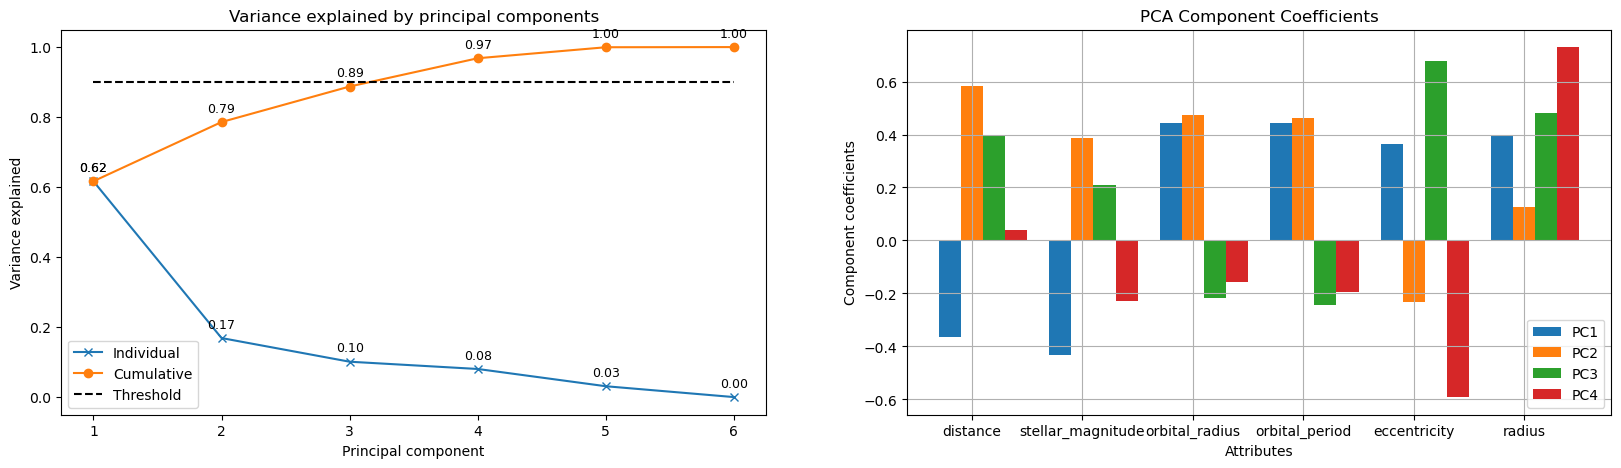

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(range(1, len(rho)+1), rho, "x-")
axs[0].plot(range(1, len(rho)+1), np.cumsum(rho), "o-")
axs[0].plot([1, len(rho)], [threshold, threshold], "k--")
axs[0].set_title("Variance explained by principal components")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Variance explained")
axs[0].legend(["Individual", "Cumulative", "Threshold"])
bw = 0.2

for i, val in enumerate(rho):
    axs[0].text(
        i + 1, 
        val + 0.02, 
        f'{val:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

r = np.arange(1, X_pca.shape[1] + 1)
axs[1].set_title("PCA Component Coefficients")
for i, pc in enumerate(V[:, :4].T):
    axs[1].bar(r + i * bw, pc, width=bw, label=f"PC{i+1}")
axs[1].set_xticks(r + bw, X_pca.columns)
axs[1].set_xlabel("Attributes")
axs[1].set_ylabel("Component coefficients")
axs[1].legend()
axs[1].grid()

for i, val in enumerate(np.cumsum(rho)):
    axs[0].text(
        i + 1, 
        val + 0.02, 
        f'{val:.2f}', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )
plt.show()

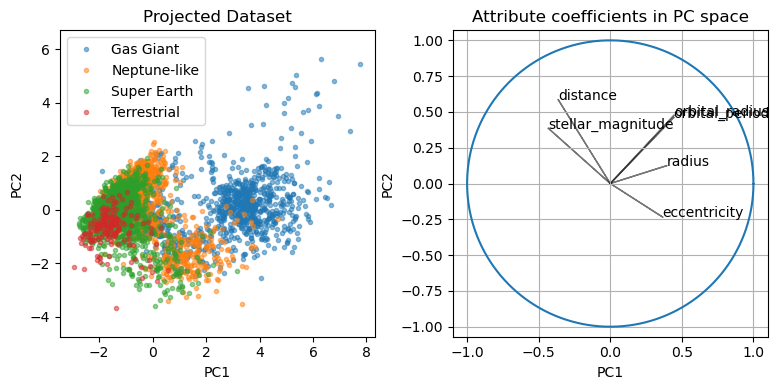

In [177]:
PC_idxs = [0, 1]
unique_types = np.unique(y_classification)

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].set_title("Projected Dataset")
for type_index in unique_types:
    mask = (y_classification == type_index)
    axs[0].plot(B[mask, PC_idxs[0]], B[mask, PC_idxs[1]], ".", alpha=0.5, label=list(planet_cats.cat.categories)[type_index])

axs[0].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[0].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[0].axis("equal")
axs[0].legend()

axs[1].set_title("Attribute coefficients in PC space")
for attr_idx, attr_name in enumerate(X_pca.columns):
    axs[1].arrow(0, 0, V[attr_idx, PC_idxs[0]], V[attr_idx, PC_idxs[1]], color='black', alpha=0.5)
    axs[1].text(V[attr_idx, PC_idxs[0]], V[attr_idx, PC_idxs[1]], attr_name)
    
axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[1].set_xlabel(f"PC{PC_idxs[0] + 1}")
axs[1].set_ylabel(f"PC{PC_idxs[1] + 1}")
axs[1].grid()
axs[1].plot(np.cos(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)))
axs[1].axis("equal")
plt.tight_layout()
plt.show()